In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

df = pd.read_parquet('../data/processed/preprocessed_data_with_embeddings_and_ohe.parquet')


In [19]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Prepare the feature matrix and target vector
X = df.drop(columns=['rating'])
y = df['rating']

# Create mappings for userId and movieId to continuous indices
user_mapping = {user_id: idx for idx, user_id in enumerate(X['userId'].unique())}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(X['movieId'].unique())}

# Map userId and movieId to continuous indices
X['userId'] = X['userId'].map(user_mapping)
X['movieId'] = X['movieId'].map(movie_mapping)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Get the number of unique users and items
num_users = len(user_mapping)
num_items = len(movie_mapping)

# Define the NCF model
embedding_dim = 20  # Reduced embedding dimension
regularization = l2(0.01)  # L2 regularization factor

user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding', embeddings_regularizer=regularization)(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding', embeddings_regularizer=regularization)(item_input)

user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

concat = Concatenate()([user_flat, item_flat])

fc1 = Dense(64, activation='relu')(concat)  # Reduced size of dense layers
drop1 = Dropout(0.2)(fc1)  # Reduced dropout rate
fc2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(fc2)
fc3 = Dense(16, activation='relu')(drop2)
output = Dense(1)(fc3)

model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Prepare the inputs
train_user_input = X_train['userId']
train_item_input = X_train['movieId']
test_user_input = X_test['userId']
test_item_input = X_test['movieId']

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit([train_user_input, train_item_input], y_train,
                    epochs=20, batch_size=256, validation_split=0.1, verbose=1, callbacks=[reduce_lr])

# Evaluate the model
y_pred = model.predict([test_user_input, test_item_input])
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.4f}')


Epoch 1/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 1842s 129ms/step - loss: 2.0891 - val_loss: 2.1569 - learning_rate: 0.0100
Epoch 2/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 637s 46ms/step - loss: 2.3200 - val_loss: 2.4639 - learning_rate: 0.0100
Epoch 3/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 632s 45ms/step - loss: 2.4368 - val_loss: 2.5824 - learning_rate: 0.0100
Epoch 4/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 634s 46ms/step - loss: 2.6895 - val_loss: 2.7726 - learning_rate: 0.0100
Epoch 5/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 683s 46ms/step - loss: 1.5475 - val_loss: 1.5377 - learning_rate: 0.0020
Epoch 6/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 682s 46ms/step - loss: 1.6140 - val_loss: 1.5720 - learning_rate: 0.0020
Epoch 7/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 634s 46ms/step - loss: 1.6485 - val_loss: 1.5737 - learning_rate: 0.0020
Epoch 8/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 688s 46ms/step - loss: 1.5669 - val_loss: 1.4914 - learning_rate: 0.0020
Epoch 9/20
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 636s 46ms/step - l

In [20]:
from keras.models import load_model

# Save the model
model.save('../models/ncf_model.keras')

# Later, to load the model
#loaded_model = load_model('../models/ncf_model.keras')


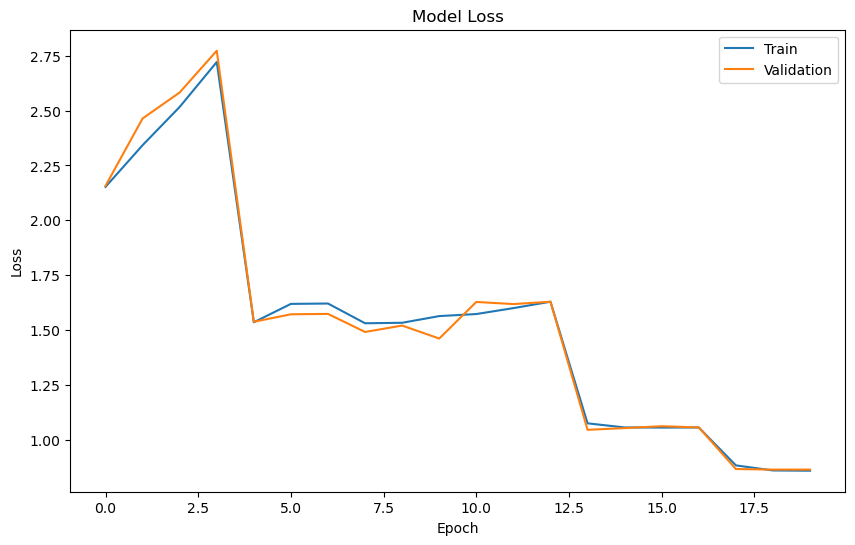

41185/41185 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step
RMSE: 0.8919
MAE: 0.6865
R^2 Score: 0.2888


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model
y_pred = model.predict([test_user_input, test_item_input])

# Calculate metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display metrics
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')


In [22]:
# Evaluate the model
y_pred = model.predict([test_user_input, test_item_input])

# Calculate regression metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R^2 Score'],
    'Value': [rmse, mae, r2]
})

# Print the metrics table
print(metrics_df)


41185/41185 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step
      Metric     Value
0       RMSE  0.891925
1        MAE  0.686544
2  R^2 Score  0.288847


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, precision_score

# Evaluate the model
y_pred = model.predict([test_user_input, test_item_input])

# Convert predictions to binary by setting a threshold (e.g., 3.5)
threshold = 3.5
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = (y_pred >= threshold).astype(int)

# Calculate regression metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate classification metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary, average='weighted')
precision = precision_score(y_test_binary, y_pred_binary, average='weighted')

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R^2 Score', 'Accuracy', 'F1 Score', 'Precision'],
    'Value': [rmse, mae, r2, accuracy, f1, precision]
})

# Print the metrics table
print(metrics_df)


41185/41185 ━━━━━━━━━━━━━━━━━━━━ 119s 3ms/step
      Metric     Value
0       RMSE  0.891925
1        MAE  0.686544
2  R^2 Score  0.288847
3   Accuracy  0.712463
4   F1 Score  0.713354
5  Precision  0.714622
